# Model baselines

This notebook is devoted to find simple models to state that data is somehow feasible to use for regression. Let's read the data:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import pydotplus
from IPython.display import Image

from widedeep.utils import *
from widedeep.data.display import *
from widedeep.data.data_ops import *

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

def mean_error(pred, truth):
    return np.mean(np.abs(pred - truth))
    
def rmse(pred, truth):
    return np.sqrt(np.mean(np.square(pred - truth)))

def median_error(pred, truth):
    return np.median(np.abs(pred - Y_test))

def print_errors(model, train_X, test_X, train_Y, test_Y):
    train_error = mean_error(model.predict(train_X), train_Y)
    train_rmse = rmse(model.predict(train_X), train_Y)
    print('[Train] Mean error on is %f and rmse is %f' % (train_error, train_rmse))
    test_error = mean_error(model.predict(test_X), test_Y)
    test_rmse = rmse(model.predict(test_X), test_Y)
    print('[Test] Mean error on is %f and rmse is %f' % (test_error, test_rmse))

def print_predictions(model, train_X, test_X):
    print('[Train] Mean prediction for model %f' % model.predict(train_X).mean())
    print('[Train] Std prediction for model %f' % model.predict(train_X).std())
    print('[Test] Mean prediction for model %f' % model.predict(test_X).mean())
    print('[Test] Std prediction for model %f' % model.predict(test_X).std())
    
data = pd.read_csv(AIRBNB_FINAL)

## Modeling prices and availability

Let's use simple approaches to predict lodging prices. We decide to use a subset of the data including 8 cities. The results we get here are a lower bound as we expect performance to improve using more data.

In [2]:
cities = data['area'].unique().tolist()
data_subset = data[data['area'].isin(cities[:8])]
print('Using %d instances and %d columns' % (data_subset.shape[0], data_subset.shape[1]))

Using 96532 instances and 72 columns


### Numerical version the data

Now we will generate an additional version of the data so it can be handled as a fully dense numerical data set. To do so, we will convert each categorical column into dummy binary features.

In [3]:
excl = ['listing_url', 'last_scraped', 'id', 'scrape_id', 'picture_url']
# Convert into boolean
num_data = convert_to_dummy(data_subset, excluded_columns=excl)
num_data = convert_boolean(num_data, func=float)

2017-02-28 20:47:42,503 - data - INFO - Converting area into dummy column ...


/home/walle/workspace/pfm/code/widedeep/data/data_ops.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[dummy_name] = data[name].apply(lambda x: is_equal(x, val))


2017-02-28 20:47:43,031 - data - INFO - Converting bed_type into dummy column ...
2017-02-28 20:47:43,143 - data - INFO - Converting cancellation_policy into dummy column ...
2017-02-28 20:47:43,236 - data - INFO - Converting country into dummy column ...
2017-02-28 20:47:43,354 - data - INFO - Converting property_type into dummy column ...
2017-02-28 20:47:43,583 - data - INFO - Converting review_scores_accuracy into dummy column ...
2017-02-28 20:47:43,676 - data - INFO - Converting review_scores_checkin into dummy column ...
2017-02-28 20:47:43,765 - data - INFO - Converting review_scores_cleanliness into dummy column ...
2017-02-28 20:47:43,856 - data - INFO - Converting review_scores_communication into dummy column ...
2017-02-28 20:47:43,945 - data - INFO - Converting review_scores_location into dummy column ...
2017-02-28 20:47:44,034 - data - INFO - Converting review_scores_rating into dummy column ...
2017-02-28 20:47:44,128 - data - INFO - Converting review_scores_value into 

## Validation set and scaling

Let's separate data between training and validation. We are also scaling data so it lies around 0 (mean 0) and the standard deviation of each column is 1.

In [5]:
# X and Y as inputs of models
excluded_cols = ['id', 'picture_url', 'scrape_id', 'listing_url', 'last_scraped', 'final_price']
features = [f for f in num_data.columns.values if f not in excluded_cols]
X, Y = num_data[features], num_data['final_price']

# Split data into training and test
train_inds, _, test_inds = split_data(len(X), 0.80, 0.10)
X_train, Y_train = X.iloc[train_inds], Y.iloc[train_inds]
X_test, Y_test = X.iloc[test_inds], Y.iloc[test_inds]

# Finally, let's generate a scaled version of the data that has mean 0 and std of 1
scaler = StandardScaler()  
scaler.fit(X_train)
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

Let's also visualize characteristics of the input target:

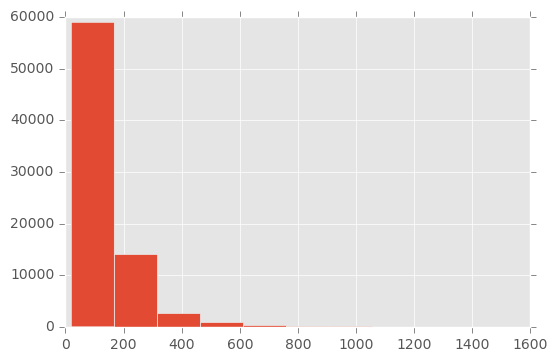

In [6]:
num_data.iloc[train_inds]['final_price'].hist()

In [27]:
print('Mean price for groundtruth %f' % num_data['final_price'].mean())
print('Std of price for groundtruth %f' % num_data['final_price'].std())

Mean price for groundtruth 135.108769
Std of price for groundtruth 117.845421


## Linear regression

We can try to approximate the price using the simplest model: a Linear Regression. This model predicts the output by performing a dot product between the input features (numeric) and the learnt weights, which minimize the distance between the predicted value and the true value.

In [7]:
# Try linear model and see coefficients
lr = LinearRegression(fit_intercept=True, normalize=False, n_jobs=2)
lr = lr.fit(X_train_s, Y_train)
coeffs = zip(features, lr.coef_)
for (n, c) in coeffs:
    print('Coefficient for %s is %f' % (n, c))

Coefficient for accommodates is 34.021419
Coefficient for bathrooms is 19.587808
Coefficient for bedrooms is 21.867947
Coefficient for beds is -10.706440
Coefficient for cleaning_fee is 10.799952
Coefficient for guests_included is 0.179351
Coefficient for host_has_profile_pic is -0.326919
Coefficient for host_identity_verified is -0.577949
Coefficient for host_is_superhost is 0.516644
Coefficient for host_verifications is -0.536095
Coefficient for instant_bookable is -0.163702
Coefficient for minimum_nights is -6.009316
Coefficient for recent_review is -2.800957
Coefficient for reviews_per_month is -2.337476
Coefficient for security_deposit is 9.723564
Coefficient for availability_365 is 7.448280
Coefficient for extra_people is -1.327708
Coefficient for suitable for events is 3.696904
Coefficient for dog(s) is 0.808290
Coefficient for safety card is -0.113453
Coefficient for pets allowed is -1.480514
Coefficient for breakfast is 1.812783
Coefficient for doorman is 1.570065
Coefficient 

Histogram of test predictions for linear regression


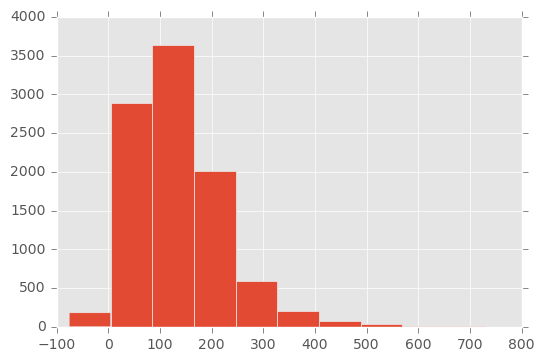

In [8]:
print('Histogram of test predictions for linear regression')
plt.hist(lr.predict(X_test_s))
plt.show()

In [19]:
print_errors(lr, X_train_s, X_test_s, Y_train, Y_test)

[Train] Mean error on is 43.545407 and rmse is 78.566039
[Test] Mean error on is 44.224596 and rmse is 78.901826


In [20]:
print_predictions(lr, X_train_s, X_test_s)

[Train] Mean prediction for linear regression 134.875514
[Train] Std prediction for linear regression 87.603776
[Test] Mean prediction for linear regression 136.187971
[Test] Std prediction for linear regression 89.054497


## Non-linear models

We know that a problem with such complexity will rarely be linear. Let's see if the results improve once we use a non-linear model such as a Multi-layer Perceptron (MLP).

In [17]:
def log_step(model, data_inp, data_gt, step, prefix):
    predicted = model.predict(data_inp)
    err = mean_error(predicted, data_gt)
    rmse_err = rmse(predicted, data_gt)
    print('[Iteration %d, Loss %f] %s error is %f and rmse is %f' 
          % (step, mlp.loss_, prefix, err, rmse_err))
    
# Train iteratively
num_steps = 100
mlp = MLPRegressor(activation='tanh', 
                   # solver='lbfgs',
                   solver='adam',
                   alpha=1e-5,
                   learning_rate_init=0.01,
                   hidden_layer_sizes=(25, 25, 25),
                   warm_start=False, 
                   max_iter=1)

# Iterative fitting of the MLP
for s in range(num_steps):
    mlp = mlp.fit(X_train_s, Y_train)
    
    # Log each 10 iterations
    if s % 10 == 0:
        log_step(mlp, X_train_s, Y_train, s, 'training')
        log_step(mlp, X_test_s, Y_test, s, 'testing')

# Extract stats from the predicted training instances
predicted = mlp.predict(X_train_s)
print('Mean of predicted data is %f' % predicted.mean())
print('Std of predicted data is %f' % predicted.std())

/home/walle/envs/ub/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[Iteration 0, Loss 10678.145537] training error is 65.090620 and rmse is 124.827214
[Iteration 0, Loss 10678.145537] testing error is 66.665803 and rmse is 128.781493
[Iteration 10, Loss 10679.792670] training error is 64.794054 and rmse is 124.549611
[Iteration 10, Loss 10679.792670] testing error is 66.582752 and rmse is 128.551278
[Iteration 20, Loss 10745.658503] training error is 65.409262 and rmse is 125.234286
[Iteration 20, Loss 10745.658503] testing error is 67.124231 and rmse is 129.256951
[Iteration 30, Loss 10645.482728] training error is 64.391453 and rmse is 124.379828
[Iteration 30, Loss 10645.482728] testing error is 66.036569 and rmse is 128.349906
[Iteration 40, Loss 10769.695013] training error is 67.414413 and rmse is 125.515573
[Iteration 40, Loss 10769.695013] testing error is 68.841991 and rmse is 129.402324
[Iteration 50, Loss 10628.570235] training error is 64.192110 and rmse is 124.291398
[Iteration 50, Loss 10628.570235] testing error is 65.929626 and rmse is

In [22]:
print_errors(mlp, X_train_s, X_test_s, Y_train, Y_test)

[Train] Mean error on is 67.462017 and rmse is 125.749575
[Test] Mean error on is 69.034453 and rmse is 129.675844


In [26]:
print_predictions(mlp, X_train_s, X_test_s)

[Train] Mean prediction for model 85.085830
[Train] Std prediction for model 8.137816
[Test] Mean prediction for model 85.124186
[Test] Std prediction for model 8.071423


Histogram of training data


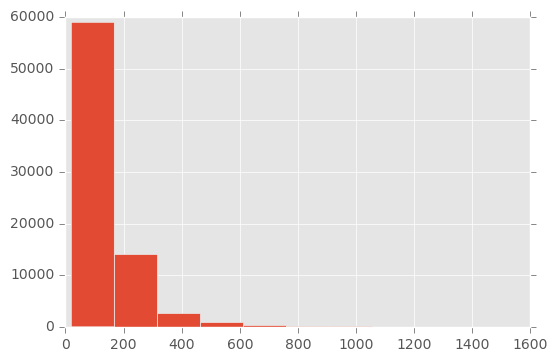

In [28]:
print('Histogram of training data')
plt.hist(Y_train)
plt.show()

Histogram of predicted data


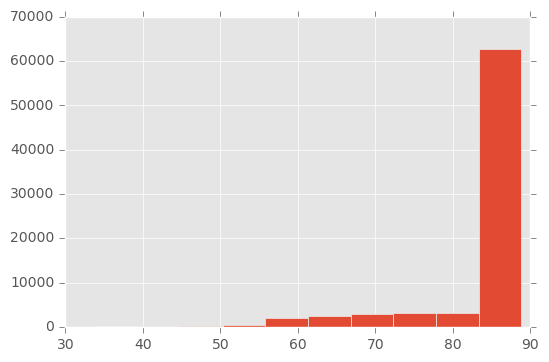

In [30]:
print('Histogram of predicted data')
plt.hist(mlp.predict(X_train_s))
plt.show()

In [57]:
test_error = np.mean(np.abs(mlp.predict(X_test_s) - Y_test))
test_error_med = np.median(np.abs(mlp.predict(X_test_s) - Y_test))
print('Mean error on test is %f. Median error is %f' % (test_error, test_error_med))

Mean error on test is 76.710651. Median error is 60.055970


## Decision trees

Let's try using decision trees.

In [33]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(min_samples_leaf=50)
clf = clf.fit(X_train_s, Y_train)

In [35]:
print_errors(clf, X_train_s, X_test_s, Y_train, Y_test)

[Train] Mean error on is 40.242171 and rmse is 76.711817
[Test] Mean error on is 43.954848 and rmse is 81.837613


In [37]:
print_predictions(clf, X_train_s, X_test_s)

[Train] Mean prediction for model 134.851392
[Train] Std prediction for model 89.133419
[Test] Mean prediction for model 135.616732
[Test] Std prediction for model 88.894533


Note that the good way to proceed would be to perform a random search over the parameters to explore and select the best configuration on the validation set (TODO)